<a id='top'></a>
# calwebb_detector1 step-by-step notebook
---
**Author**: Jonathan Aguilar (jaguilar@stsci.edu) | **Latest Update**: 8 Nov 2023

* [Introduction](#intro)
* [Pipeline Resources and Documentation](#resources)
* [Non-pipeline imports](#imports)
* [Convenience tools](#convenience_tools)
* [Select the uncal file](#file_selection)
* [Run the individual pipeline steps](#detector1_step_by_step)
   * [Import the pipeline steps](#import_pipeline)
   * [The `Data Quality Initialization` step](#dq_init)
   * [The `Saturation Flagging` step](#saturation)
   * [The `First Frame Correction` step](#firstframe)
   * [The `Last Frame Correction` step](#lastframe)
   * [The `Linearity Correction` step](#linearity)
   * [The `Reset Switch Charge Decay Correction` step](#rscd)
   * [The `Dark Current Subtraction` step](#dc)
   * [The `Reference Pixel Subtraction` step](#refpix)
   * [The `Cosmic Ray Flagging` step](#jump)
   * [The `Ramp_Fitting` step](#ramp_fitting)
   * [Saving to rate/rateints](#close_out)

<a id='intro'></a>
## Introduction

The Stage 1 JWST pipeline takes 4-D data in units of DN (Data Number, a unit used to label uncalibrated counts coming from the detector readout electronics), and performs various detector corrections to transform it into an uncalibrated 3-D slope cube (`_rateints.fits`) (or 2-D slope image, `_rate.fits`) with units of DN/sec. 

This notebook breaks the calwebb_detector1 (also called Detector1Pipeline) pipeline class into steps, runs each independently, and examines the output. It demonstrates how to change step-specific parameters at the step level. Much of the material, especially the documentation, is based on the example notebook found [here](https://github.com/spacetelescope/jwebbinar_prep/blob/main/pipeline_inflight/imaging_mode_stage_1.ipynb), written by Bryan Hilbert. Materials and videos can be found [here](https://www.stsci.edu/jwst/science-execution/jwebbinars) under JWebbinar 18. Here, it has been tailored to the specific case of MIRI coronagraphy.

The primary purpose of this notebook is to provide an example of each Stage 1 step and how its parameters are set. Users can then easily modify a single step and examine its output without having to run the entire Stage1 pipeline. 

<a id='resources'></a>
## Pipeline resources and documentation

Documentation on `calwebb_detector1` and the steps run on MIRI coronagraphy data specifically can be found here: https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html#calwebb-detector1

We also refer the user to the Imaging example notebook: https://github.com/spacetelescope/jwebbinar_prep/blob/main/pipeline_inflight/imaging_mode_stage_1.ipynb. This contains a wealth of information that has been omitted here for brevity.

For more pipeline notebooks, see the examples https://github.com/spacetelescope/jwebbinar_prep/tree/main/pipeline_inflight.


<a id='imports'></a>
## Non-pipeline imports

In [1]:
import os
from collections import OrderedDict
from pathlib import Path

In [2]:
import numpy as np

In [3]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from astropy.io import fits

<a id='convenience_tools'></a>
## Convenience tools

Environment paths and functions that make life easier.

First, set up a local CRDS directory. When the pipeline pulls a reference file from CRDS for the first time, it will write a copy to this directory. All subsequent reads of the reference file will redirect to the local directory instead of sending the file again over the network.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/user_documentation/reference_files_crds.html#crds

In [4]:
os.environ['CRDS_PATH'] = '/Volumes/agdisk/crds/'
# os.environ['CRDS_PATH'] = ''
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

Advanced users - uncomment the cell below and specify the context if you have a specific combination of reference files you want to use

In [5]:
# os.environ['CRDS_CONTEXT'] = 'jwst_1140.pmap'

In [6]:
# some plot formatting
mpl.rcParams['image.origin'] = "lower"

In [7]:
# uncomment for in-line plots
%matplotlib inline
# uncomment for pop-up plots
# In my setup, this command needs to be run twice
# %matplotlib auto
# %matplotlib auto

In [8]:
# this helper function to map out a particular DQ flag will be useful
# DQ flags can be found here: 
# https://jwst.readthedocs.io/en/latest/jwst/references_general/references_general.html#data-quality-flags
def get_dq_flag(flag, dq_img):
    """return the pixels that have a given DQ flag"""
    bad_bitvalue = dqflags.pixel[flag]
    flags = np.bitwise_and(dq_img, bad_bitvalue).astype(bool)
    return flags

### Logging configuration

The logging statements can be quite extensive, which can make a notebook cumbersome to read on Github in an executed state. To help the users, we're going to redirect the logging statements to log files stored in each step's output folder. That way you the notebook will be stripped down to the commands and diagnostic output, but the logging statements are preserved so users can compare them against the output in their own notebooks. 

In the cell below you'll find the template to the logging configuration file. The logging configuration file contains the path to the log file and the level of verbosity. At each step, we will call the `generate_log_file` function to create a config file, and pass that file to the step. The step will then generate a log file in the output directory.

In [9]:
cfg_template = """
[*]
handler = file:path_to_file
level = INFO
"""
def generate_log_file(output_dir):
    cfgfile_name = Path(output_dir).stem + ".cfg"
    logfile_name = Path(output_dir).stem + ".log"
    cfg = cfg_template.replace("path_to_file", str(output_dir / logfile_name))
    cfgfile_path = output_dir / cfgfile_name
    with open(str(cfgfile_path), 'w') as f:
        f.write(cfg)
    return str(cfgfile_path) if cfgfile_path.exists() else None

<a id="file_selection"></a>
## Select the uncal file

The cell below will retrieve Observation 7 of the High-contrast ERS program (PID 1386), from MAST. 

If you would like to use a different exposure, please direct the `uncal_file` variable to the desired file.

In [10]:
from astroquery.mast import Observations
filename = "jw01386007001_04101_00001_mirimage_uncal.fits"
Observations.download_file(f"mast:JWST/product/{filename}", local_path= f"./uncal/{filename}")
uncal_file = f"./uncal/{filename}"

INFO: Found cached file ./uncal/jw01386007001_04101_00001_mirimage_uncal.fits with expected size 306489600. [astroquery.query]


Let's do a quick inspection of the file. We see it is 4 dimensional, with the last two axes representing detector x and y coordinates, and the first two representing each group, and each integration.

In [11]:
# print some basic information
fits.info(uncal_file)

Filename: ./uncal/jw01386007001_04101_00001_mirimage_uncal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     182   ()      
  1  SCI           1 ImageHDU        80   (288, 224, 100, 19)   int16 (rescales to uint16)   
  2  REFOUT        1 ImageHDU        13   (288, 56, 100, 19)   int16 (rescales to uint16)   
  3  GROUP         1 BinTableHDU     38   38R x 13C   [I, I, I, J, I, 26A, I, I, I, I, 36A, D, D]   
  4  INT_TIMES     1 BinTableHDU     24   19R x 7C   [J, D, D, D, D, D, D]   
  5  ASDF          1 BinTableHDU     11   1R x 1C   [8067B]   


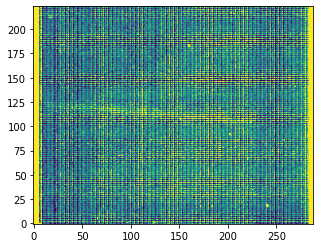

In [12]:
# a simple plot - there isn't much to see yet
fig, ax = plt.subplots(1, 1)
img = fits.getdata(uncal_file, 1)
img = np.nanmean(img, axis=(0, 1))
imlims = dict(zip(['vmin', 'vmax'], np.nanquantile(img, [0.1, 0.9])))
ax.imshow(img, **imlims, origin='lower')

<a id='detector1_step_by_step'></a>
## Run each step of calwebb_detector1

We're going to save the output of each step separately, so the code below generates an output folder for each step. We will be running only the steps that are relevant to the MIRI coronagraphy pipeline.

The steps, in order of execution, are:
- `dq_init`
    - data quality initialization
    - populates the DQ mask for the input dataset
    - no step-specific arguments
    - reference file: MASK
- `saturation`
    - flags pixels at or below the A/D floor (< 0 DN) or above the saturation threshold
    - no step-specific arguments
    - reference file: SATURATION
- `firstframe`
    - only for MIRI; flags the first group in every integration as bad (sets DO_NOT_USE DQ bit)
    - no step-specific arguments
    - no reference file used
- `lastframe`
    - only for MIRI; flags the final group in each integration as bad (sets DO_NOT_USE DQ bit)
    - no step-specific arguments
    - no reference file used
- `linearity`
    - linearity correction
    - correction is applied pixel-by-pixel, group-by-group, integration-by-integration within a science exposure
    - no step-specific arguments
    - reference file: LINEARITY
- `rscd`
    - Reset Switch Charge Decay (RSCD) Correction
    - only for MIRI, and only applied after the first integration
    - flags N groups as DO_NOT_USE if the charge in the reset switches has not sufficienty decayed?
    - no step-specific arguments
    - reference file: RSCD    
- `dark_current`
    - dark current subtraction
    - subtracts dark current data stored in a dark reference file
    - one step-specific argument:
        - `dark_output filename`; saves the frame-averaged dark data to this file
    - reference file: DARK    
- `refpix`
    - reference pixel correction
    - uses reference pixels to correct for drifts in the readout amplifiers
    - step arguments:
        - `odd_even_columns bool [True]`; odd and even columns are treated separately
        - `use_side_ref_pixels bool [True]`; only for NIR data
        - `side_smoothing_length int [11]`: height of the window used for the running median calculation
        - `side_gain float [1.0]` how much to multiply the side reference signal before subtraction
        - `odd_even_rows bool [True]` calculate reference signal separately for odd and even rows; only for MIR
    - reference file: DARK    
- `jump`
    - detects jumps in an exposure (after saturation step has been applied)
    - looks for outliers in up-the-ramp read
    - skips automatically if ngroups/integration < 3
    - step-specific arguments:
        - `rejection_threshold float [4.0]` sigma rejection threshold
        - `maximum_cores string [none]` fraction of available cores to use
        - `flag_4_neighbors bool [True]` if jump is detected, flag 4 neighbors as jumps too
        - `max_jump_to_flag_neighbors float [200]` sigma threshold to limit automatic neighbor flagging (so they will be flagged as primary jumps, and *their* neighbors can be flagged
        - `min_jump_to_flag_naighbors float [10]` limits flagging of neighbors of marginal jump detections.
    - two reference files:
        - GAIN
        - READNOISE
- `ramp_fitting`
    - fits a line to the group data in the input file to determine the count rate
    - step-specific arguments:
        - `save_opt bool [False]` write optional output product
        - `opt_name str` overrides the default name for the output product
        - `int_name str` overrides the default name for the per-integration product
        - `maximum_cores str [none]` fraction of cores to use for multiprocessing
    - reference files: 
        - GAIN
        - READNOISE

<a id='import_pipeline'></a>
### Import the pipeline steps

In [13]:
import jwst
jwst.__version__

'1.11.3'

In [14]:
from jwst import datamodels
from jwst.datamodels import dqflags

In [15]:
from jwst.pipeline import Detector1Pipeline
from jwst.dq_init import DQInitStep
from jwst.saturation import SaturationStep
from jwst.firstframe import FirstFrameStep
from jwst.lastframe import LastFrameStep
from jwst.linearity import LinearityStep
from jwst.rscd import RscdStep
from jwst.dark_current import DarkCurrentStep
from jwst.refpix import RefPixStep
from jwst.jump import JumpStep
from jwst.ramp_fitting import RampFitStep

### Set up the output storage

We're going to write out the results of each step to disk, and also keep a copy in memory in the `results` dict generated in the cell below.

In [16]:
# The get_pars() method returns a dictionary of allowed parameters for the pipeline stage, including
# a dictionary of parameters for each step. We will use this dictionary to get a list of steps that will
# index our results dictionary.
results = OrderedDict([(step, None) for step in Detector1Pipeline().get_pars()['steps'].keys()])

# clean out steps that are skipped by the coronagraphy pipeline
results.pop("group_scale")
results.pop("ipc")
results.pop("superbias") 
results.pop("reset")
results.pop("gain_scale") 

2023-11-16 11:40:20,452 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2023-11-16 11:40:20,454 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2023-11-16 11:40:20,456 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2023-11-16 11:40:20,457 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2023-11-16 11:40:20,458 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2023-11-16 11:40:20,459 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2023-11-16 11:40:20,461 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2023-11-16 11:40:20,462 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2023-11-16 11:40:20,465 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2023-11-16 11:40:20,471 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2023-11-16 1

In [17]:
print("Here is a list of the different steps:")
for step in results.keys():
    print("\t" + step)

Here is a list of the different steps:
	dq_init
	saturation
	refpix
	rscd
	firstframe
	lastframe
	linearity
	dark_current
	persistence
	jump
	undersampling_correction
	ramp_fit


For this notebook, each step will get its own output folder: `output/{step_name}`

Generate the output folders specific to this notebook (do nothing if they already exist).

In [18]:
output_parent = Path(f"./stage1/output-steps/")
for k in results.keys():
    p = output_parent / k
    if not p.exists():
        p.mkdir(parents=True)
        print(str(p.resolve()), "made")
    else:
        print(f"{str(p)} found")

stage1/output-steps/dq_init found
stage1/output-steps/saturation found
stage1/output-steps/refpix found
stage1/output-steps/rscd found
stage1/output-steps/firstframe found
stage1/output-steps/lastframe found
stage1/output-steps/linearity found
stage1/output-steps/dark_current found
stage1/output-steps/persistence found
stage1/output-steps/jump found
stage1/output-steps/undersampling_correction found
stage1/output-steps/ramp_fit found


ASDF datamodels are the native data format used by the pipeline, so we're going to use them here

In [19]:
init_dm = datamodels.open(uncal_file)

Add the starting data ("uncal") to the results dict

In [20]:
results['init'] = init_dm

<a id="dq_init"></a>
## DQ Init

https://stdatamodels.readthedocs.io/en/latest/jwst/datamodels/index.html#data-models

Populates the DQ header

The dq_init step has no step-specific arguments.

In [21]:
output_dir = output_parent / "dq_init"

In [22]:
results['dq_init'] = DQInitStep.call(
    results['init'],
    # common
    save_results=True, 
    output_dir=str(output_dir),
    logcfg=generate_log_file(output_dir)
    # step-specific
)

In [23]:
try:
    assert(results['dq_init'].data.shape == init_dm.data.shape)
except AssertionError:
    for k in ['init', 'dq_init']:
        print(k, results[k].data.shape)

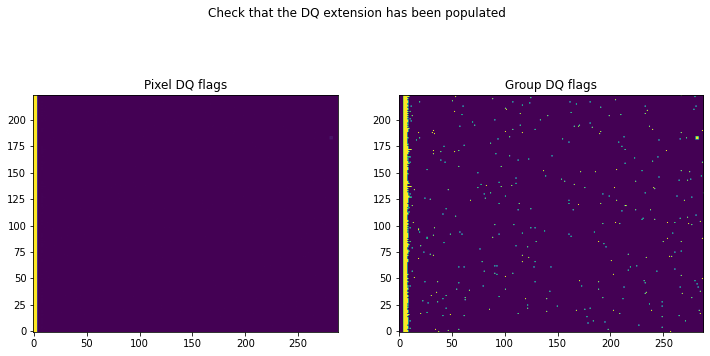

In [24]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(12, 6))

fig.suptitle("Check that the DQ extension has been populated")

ax = axes[0]
ax.set_title(f"Pixel DQ flags")

img = results['dq_init'].pixeldq

ax.imshow(img);

ax = axes[1]
ax.set_title(f"Group DQ flags")
img = np.nanmax(results['dq_init'].groupdq, axis=(0, 1))
ax.imshow(img);

<a id="saturation"></a>
## Saturation

https://jwst-pipeline.readthedocs.io/en/latest/jwst/saturation/index.html#saturation-step

The saturation step flags pixels at or below the A/D floor or above the saturation threshold. Pixels values are flagged as saturated if the pixel value is larger than the defined saturation threshold. Pixel values are flagged as below the A/D floor if they have a value of zero DN.

The saturation step has one step-specific argument:
- n_pix_grow_sat: (2xn + 1) the distance to use when growing saturation flag values to neighboring pixels, in order to account for charge migration (spilling)

In [25]:
output_dir = output_parent / "saturation"

Let's test two different values of `n_pix_grow_sat`: 1, and 5

N.B. this step can take a few minutes to run.

In [26]:
sat1 = SaturationStep.call(
    results['dq_init'],
    # common
    save_results=True, 
    output_dir=str(output_dir),
    logcfg=generate_log_file(output_dir),
    # step-specific arguments
    n_pix_grow_sat = 1, # default is 1
)
sat5 = SaturationStep.call(
    results['dq_init'],
    # common
    save_results=True, 
    output_dir=str(output_dir),
    logcfg=generate_log_file(output_dir),
    # step-specific arguments
    n_pix_grow_sat = 5, # default is 1
)
results['saturation'] = sat1 # use the default parameter moving forward

Check pixels for saturation flags

In [27]:
# find all the pixels flagged "SATURATED"
dq_imgs = {}
flag = "SATURATED"
for s, satdm in [('sat1', sat1), ('sat5', sat5)]: 
    dq_imgs[s] = get_dq_flag(flag, satdm.groupdq)

In [28]:
for satval, dq_img in dq_imgs.items():
    print(f"{satval}: {dq_img[dq_img.astype(bool)].size:10d} pix flagged")

sat1:      85248 pix flagged
sat5:     495410 pix flagged


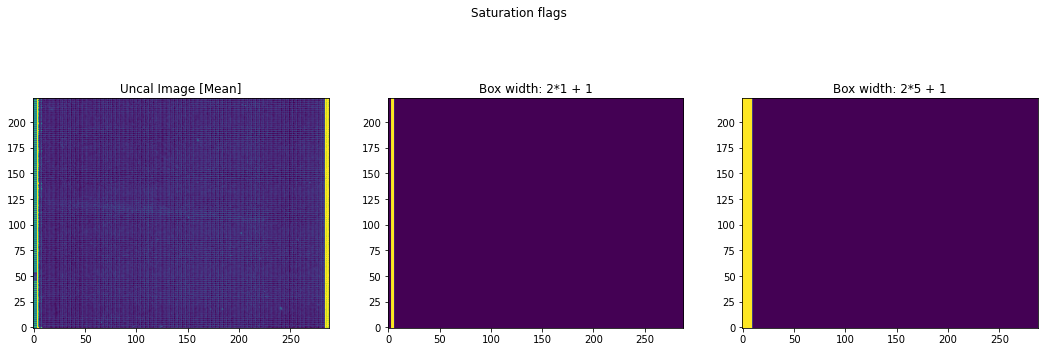

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3*6, 1*6))
fig.suptitle("Saturation flags")

ax = axes[0]
ax.set_title("Uncal Image [Mean]")
init_img = np.nanmean(init_dm.data, axis=(0, 1))
vmin, vmax = np.nanquantile(init_img, [0.01, 0.99])
ax.imshow(init_img, vmin=vmin, vmax=vmax)

ax = axes[1]
ax.set_title("Box width: 2*1 + 1")
ax.imshow(dq_imgs['sat1'].any(axis=(0, 1)))

ax = axes[2]
ax.set_title("Box width: 2*5 + 1")
ax.imshow(dq_imgs['sat5'].any(axis=(0, 1)))

<a id="firstframe"></a>
## First Frame Correction

https://jwst-pipeline.readthedocs.io/en/latest/jwst/firstframe/index.html#firstframe-step

The MIRI first frame correction step flags the first group in every integration as bad (the “DO_NOT_USE” data quality flag is added to the GROUPDQ array), but only if the total number of groups per integration is greater than 3.

The first frame correction has no step-specific arguments.

In [30]:
output_dir = output_parent / "firstframe"

In [31]:
results['firstframe'] = FirstFrameStep.call(
    results['saturation'],
    # common
    save_results=True, 
    output_dir=str(output_dir),
    logcfg=generate_log_file(output_dir),
    # step-specific - None
)

In [32]:
# get the DO_NOT_USE flag
donotuse = get_dq_flag("DO_NOT_USE", results['firstframe'].groupdq)

In [33]:
donotuse.shape

(19, 100, 224, 288)

In [34]:
# check that the first frame is flagged all DO_NOT_USE
try:
    assert(donotuse[:, 0].all())
except AssertionError:
    print("Error!! First frame is not flagged all DO_NOT_USE.")

In [35]:
# check that the second frame is NOT flagged all DO_NOT_USE
try:
    assert(not donotuse[:, 1].all())
except AssertionError:
    print("Error!! Second frame *is* flagged all DO_NOT_USE.")

<a id='lastframe'></a>
## Last Frame Correction

https://jwst-pipeline.readthedocs.io/en/latest/jwst/lastframe/index.html#lastframe-step

Flags the final group in each integration as bad (the “DO_NOT_USE” bit is set in the GROUPDQ flag array), but only if the total number of groups in each integration is greater than 2.

The last frame correction has no step-specific arguments.

In [36]:
output_dir = output_parent / "lastframe"

In [37]:
results['lastframe'] = LastFrameStep.call(
    results['firstframe'],
    # common
    save_results=True,
    output_dir=str(output_dir),
    logcfg=generate_log_file(output_dir),
    # step-specific - None
)

In [38]:
# get the DO_NOT_USE flag
donotuse = get_dq_flag("DO_NOT_USE", results['lastframe'].groupdq)

In [39]:
# check that the last frame is flagged all DO_NOT_USE
try:
    assert(donotuse[:, -1].all())
except AssertionError:
    print("Error!! Last frame is all DO_NOT_USE.")

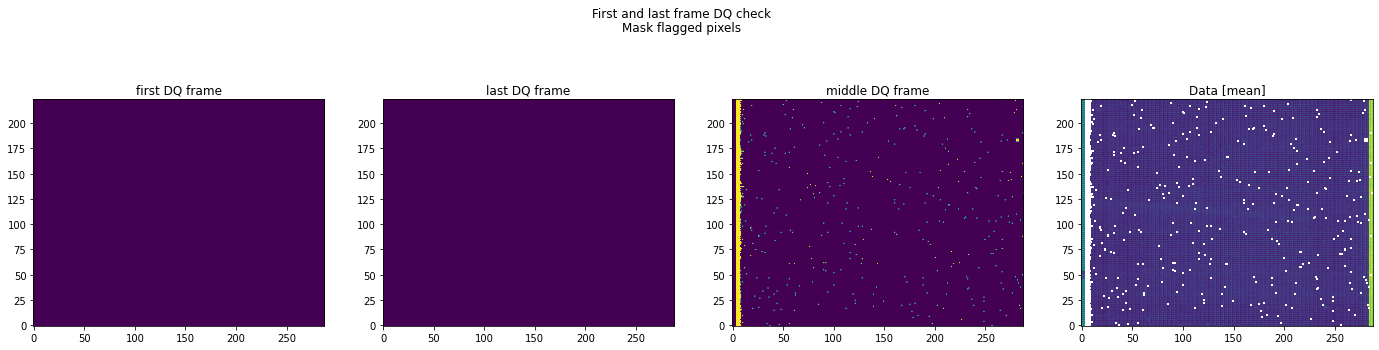

In [40]:
nrows, ncols = 1, 4

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows))
fig.suptitle("First and last frame DQ check\nMask flagged pixels")

ax = axes[0]
ax.set_title("first DQ frame")
ax.imshow(donotuse[:, 0].any(axis=0))

ax = axes[1]
ax.set_title("last DQ frame")
ax.imshow(donotuse[:, -1].any(axis=0))

ax = axes[2]
ax.set_title("middle DQ frame")
ax.imshow(donotuse[:, 1].any(axis=0))

ax = axes[3]
ax.set_title("Data [mean]")
ax.imshow(np.nanmean(np.ma.masked_array(results['lastframe'].data, mask=donotuse), axis=(0, 1)))


In [41]:
# check that the second-to-last frame is NOT flagged all DO_NOT_USE
try:
    assert(not donotuse[:, -2].all())
except AssertionError:
    print("Error!! Second-to-last frame is all DO_NOT_USE.")
    

<a id='linearity'></a>
## Linearity

https://jwst-pipeline.readthedocs.io/en/latest/jwst/linearity/index.html#linearity-step

The linearity step applies the “classic” linearity correction adapted from the HST WFC3/IR linearity correction routine, correcting science data values for detector non-linearity.

The linearity correction has no step-specific arguments.

In [42]:
output_dir = output_parent / "linearity"

In [43]:
results['linearity'] = LinearityStep.call(
    results['lastframe'],
    # common
    save_results=True,
    output_dir=str(output_dir),
    logcfg=generate_log_file(output_dir),
    # step-specific - None
)

In [44]:
# get the ramps for 6 randomly chosen pixels
npix = 6
pixels = np.random.randint(15, 200, npix*2).reshape((npix, 2))
ramps = {
    step: 
    np.stack([[i[1:-1, p[0], p[1]] for p in pixels] for i in results[step].data])
    for step in ['lastframe', 'linearity']
}

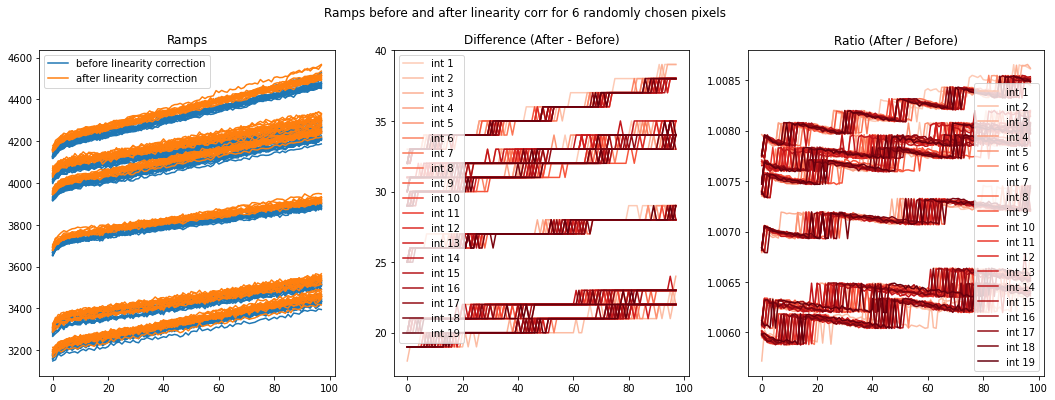

In [45]:
# let's plot some groups

nrows, ncols = 1, 3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows))

fig.suptitle(f"Ramps before and after linearity corr for {npix} randomly chosen pixels")

ax = axes[0]
ax.set_title("Ramps")

for ramp in np.stack(ramps['lastframe']):
    ax.plot(ramp.T, color='C0')
for ramp in np.stack(ramps['linearity']):
    ax.plot(ramp.T, color='C1')

ax.plot([], [], color='C0', label='before linearity correction')
ax.plot([], [], color='C1', label='after linearity correction')
ax.legend()

ax = axes[1]
ax.set_title("Difference (After - Before)")

diff = np.stack(ramps['linearity']) - np.stack(ramps['lastframe'])
colors = mpl.cm.Reds(np.linspace(0.2, 1, len(diff)))
for i, ramp in enumerate(diff):
    ax.plot(ramp.T, c=colors[i])
    ax.plot([], label=f'int {i+1}', c=colors[i])    
ax.legend()

ax = axes[2]
ax.set_title("Ratio (After / Before)")

diff = np.stack(ramps['linearity']) / np.stack(ramps['lastframe'])
colors = mpl.cm.Reds(np.linspace(0.2, 1, len(diff)))
for i, ramp in enumerate(diff):
    ax.plot(ramp.T, c=colors[i])
    ax.plot([], label=f'int {i+1}', c=colors[i])    
ax.legend()


<a id='rscd'></a>
## Rscd

https://jwst-pipeline.readthedocs.io/en/latest/jwst/rscd/index.html#rscd-st

The Reset Switch Charge Decay (RSCD) step corrects for some electronics effects by simply flagging the first N groups as DO_NOT_USE. 

The rscd correction has no step-specific arguments.

In [46]:
output_dir = output_parent / "rscd"

In [47]:
results['rscd'] = RscdStep.call(
    results['linearity'], 
    # common
    save_results=True,
    output_dir=str(output_dir),
    logcfg=generate_log_file(output_dir),
    # step-specific - None
)

In [48]:
dnu_count = {}
for step in ['linearity', 'rscd']:
    flagmap = get_dq_flag('DO_NOT_USE', results[step].groupdq)
    dnu_count[step] = flagmap
for step, flagmap in dnu_count.items():
    print(f"{step:10s}: {flagmap[flagmap.astype(bool)].size:10d} DO_NOT_USE pixels")

linearity :    5030422 DO_NOT_USE pixels
rscd      :    8439280 DO_NOT_USE pixels


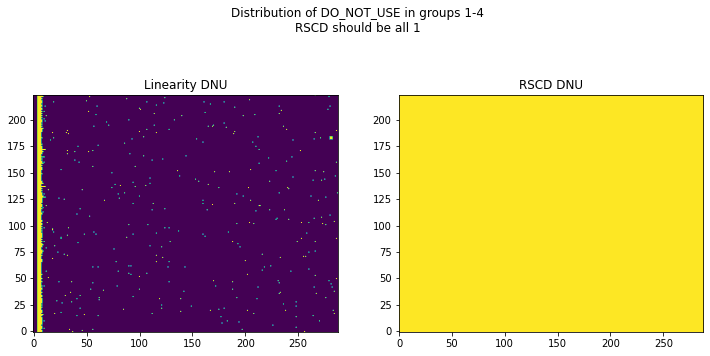

In [49]:
# let's plot some groups
nrows, ncols = 1, 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows))
fig.suptitle("Distribution of DO_NOT_USE in groups 1-4\nRSCD should be all 1")

vmin, vmax= 0, 1

ax = axes[0]
ax.set_title("Linearity DNU")
ax.imshow(dnu_count['linearity'][:, 1:4].astype(bool).any(axis=(0, 1)), vmin=0, vmax=1)

ax = axes[1]
ax.set_title("RSCD DNU")
ax.imshow(dnu_count['rscd'][:, 1:4].astype(bool).any(axis=(0, 1)), vmin=0, vmax=1)

<a id='dc'></a>
## Dark Current

https://jwst-pipeline.readthedocs.io/en/latest/jwst/dark_current/index.html#dark-current-step

The dark current step removes dark current from an exposure by subtracting dark current data stored in a dark reference file in CRDS.

The dark current step has one step-specific argument:
- "dark_output": file to save the frame-averaged dark data

In [50]:
output_dir = output_parent / "dark_current"

In [51]:
results['dark_current'] = DarkCurrentStep.call(
    results['rscd'], 
    # common
    save_results=True, 
    output_dir=str(output_dir),
    logcfg=generate_log_file(output_dir),
    # step-specific
    dark_output= output_dir / "dark.fits",
)

In [52]:
# get the ramps for 6 randomly chosen pixels
npix = 6
pixels = np.random.randint(15, 200, npix*2).reshape((npix, 2))
ramps = {
    step: 
    np.stack([[i[1:-1, p[0], p[1]] for p in pixels] for i in results[step].data])
    for step in ['rscd', 'dark_current']
}

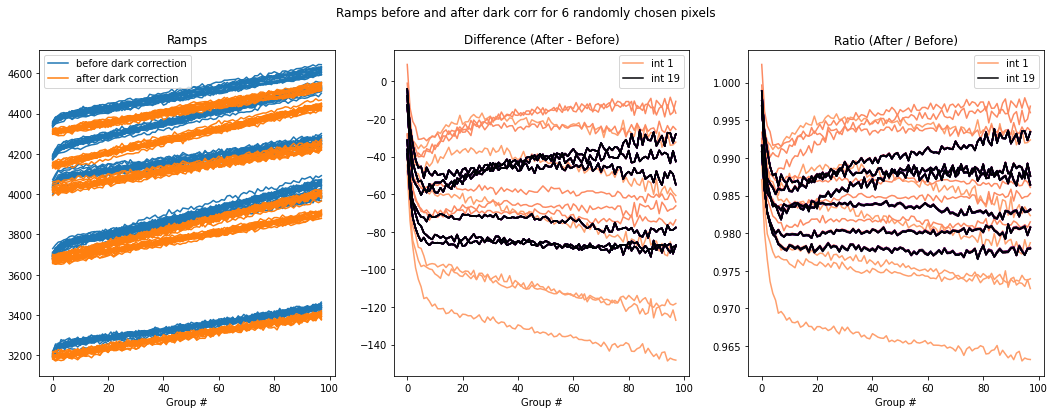

In [53]:
# let's plot some groups

nrows, ncols = 1, 3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows))

fig.suptitle(f"Ramps before and after dark corr for {npix} randomly chosen pixels")

ax = axes[0]
ax.set_title("Ramps")

for ramp in np.stack(ramps['rscd']):
    ax.plot(ramp.T, color='C0')
for ramp in np.stack(ramps['dark_current']):
    ax.plot(ramp.T, color='C1')

ax.plot([], [], color='C0', label='before dark correction')
ax.plot([], [], color='C1', label='after dark correction')
ax.legend()

ax = axes[1]
ax.set_title("Difference (After - Before)")

diff = np.stack(ramps['dark_current']) - np.stack(ramps['rscd'])
colors = mpl.cm.magma_r(np.linspace(0.2, 1, len(diff)))
for i, ramp in enumerate(diff):
    ax.plot(ramp.T, c=colors[i])

ax.plot([], label=f'int 1', c=colors[0])
ax.plot([], label=f'int {len(diff)}', c=colors[-1])    
ax.legend()

ax = axes[2]
ax.set_title("Ratio (After / Before)")

diff = np.stack(ramps['dark_current']) / np.stack(ramps['rscd'])
colors = mpl.cm.magma_r(np.linspace(0.2, 1, len(diff)))
for i, ramp in enumerate(diff):
    ax.plot(ramp.T, c=colors[i])
ax.plot([], label=f'int 1', c=colors[0])
ax.plot([], label=f'int {len(diff)}', c=colors[-1])    
ax.legend()

for ax in axes.ravel():
    ax.set_xlabel("Group #")

<a id="refpix"></a>
## Refpix

https://jwst-pipeline.readthedocs.io/en/latest/jwst/refpix/index.html#refpix-step

The refpix step corrects for drifts by using the reference pixels.

Step-specific parameters:
- odd_even_rows: True
    - The reference signal is calculated and applied separately for even- and odd-numbered rows. MIR data only.
- The following arguments do not apply to MIR data
    - odd_even_columns: True
        - Odd/Even columns are corrected separately. NIR data only.
    - use_side_ref_pixels: True
        - Side reference pix are used to correct by row. NIR data only.
    - side_smoothing_length: 11
        - The height of the window used in calculating the running median when calculating the side reference signal.
    - side_gain: 1.0
        - The factor that the side reference signal is multiplied by before subtracting from the group row-by-row..
    - ovr_corr_mitigation_ftr: 1.8
        - Avoid overcorrection of intermittently bad reference pixels in the IRS2 algorithm. NIRSpec/IRS2 data only.

In [54]:
output_dir = output_parent / "refpix"

In [55]:
results['refpix'] = RefPixStep.call(
    results['dark_current'], 
    # common
    save_results=True,
    output_dir=str(output_dir),
    logcfg=generate_log_file(output_dir),
    # step-specific
    odd_even_rows = True,
)

In [56]:
donotuse = get_dq_flag("DO_NOT_USE", results['refpix'].groupdq)

# donotuse = dq_tools.separate_dq_flags(results['refpix'].groupdq.copy(), 'DO_NOT_USE')['DO_NOT_USE']
refpix_masked = np.ma.masked_array(results['refpix'].data, mask=donotuse)
dc_masked = np.ma.masked_array(results['dark_current'].data, mask=donotuse)

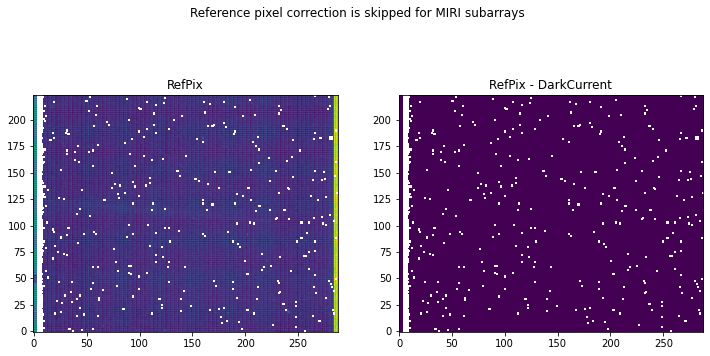

In [57]:
nrows, ncols = 1, 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows))
fig.suptitle("Reference pixel correction is skipped for MIRI subarrays")

ax = axes[0]
ax.set_title("RefPix")
ax.imshow(np.nanmean(refpix_masked[:, 1:-1], axis=(0, 1))
         )

ax = axes[1]
ax.set_title("RefPix - DarkCurrent")
ax.imshow(np.nanmean(refpix_masked - dc_masked, axis=(0, 1))
         )

<a id='jump'></a>
## Jump

N.B. this step can take a while, especially if you have "maximum_cores" set to None. If you're running on a personal laptop, consider using "half". 

https://jwst-pipeline.readthedocs.io/en/latest/jwst/jump/index.html#jump-step

Detects jumps in the ramp and sets flags in the DQ array

30 optional arguments that can be set by the user:

- rejection_threshold: 4.0
    - A floating-point value that sets the sigma threshold for jump detection
- three_group_rejection_threshold: 6.0
    - Cosmic ray sigma rejection threshold for ramps having 3 groups
- four_group_rejection_threshold: 5.0
    - Cosmic ray sigma rejection threshold for ramps having 4 groups
- maximum_cores: 'none'
    - The number of available cores that will be used for multi-processing in this step. 
    - integer, 'quarter', 'half', 'all', 'none'
- flag_4_neighbors: True
    - will cause the four perpendicular neighbors of all detected jumps to also be flagged as a jump. This is needed because of the inter-pixel capacitance (IPC).
- max_jump_to_flag_neighbors: 1000.0
    - Any jump above this cutoff will not have its neighbors flagged
- min_jump_to_flag_neighbors: 10.0
    - Any primary jump below this value will not have its neighbors flagged.
- after_jump_flag_dn1: 0.0
- after_jump_flag_time1: 0.0
    - After a jump of at least ‘after_jump_flag_dn1’ DN, groups up to ‘after_jump_flag_time1’ seconds will also be flagged as jumps.
- after_jump_flag_dn2: 0.0
- after_jump_flag_time2: 0.0
    - after a jump of at least ‘after_jump_flag_dn2’ DN, groups up to ‘after_jump_flag_time2’ seconds will also be flagged as jumps.
- min_sat_area: 1.0
    - The minimum number of saturated pixels required to meet “sat_required_snowball”.
- min_jump_area: 5.0
    - The minimum number of contiguous pixels needed to trigger the expanded flagging of large cosmic rays events.
- expand_factor: 2.0
    - A multiplicative factor applied to the enclosing ellipse for snowballs
- use_ellipses: False
    - deprecated
- sat_required_snowball: True
    - requires that there are saturated pixels within the enclosed jump circle.
- min_sat_radius_extend: 2.5
    - The minimum radius of the saturated core of a snowball required to for the radius of the saturated core to be extended.
- sat_expand: 2
    - Number of pixels to add to the radius of the saturated core of snowballs
- expand_large_events: False
    - controls whether the jump step will expand the number of pixels that are flagged around large cosmic ray events
- find_showers: False
    - Turn on the detection of showers for the MIRI detectors
- edge_size: 25
    - The distance from the edge of the detector where saturated cores are not required for snowball detection
- extend_snr_threshold: 1.2
    - The SNR minimum for the detection of faint extended showers in MIRI
- extend_min_area: 90
    - The required minimum area of extended emission after convolution for the detection of showers in MIRI
- extend_inner_radius: 1.0
    - The inner radius of the ring_2D_kernel that is used for the detection of extended emission in showers
- extend_outer_radius: 2.6
    - The outer radius of the ring_2D_kernel that is used for the detection of extended emission in showers
- extend_ellipse_expand_ratio: 1.1
    - ultiplicative factor to expand the radius of the ellipse fit to the detected extended emission in MIRI showers
- time_masked_after_shower: 15.0
    - Number of seconds to flag groups as jump after a detected extended emission in MIRI showers
- max_extended_radius: 200
    - he maxiumum extension of the jump and saturation that will be flagged for showers or snowballs
- minimum_groups: 3
    - he minimum number of groups to run the jump step with sigma clipping
- minimum_sigclip_groups: 100
    - The minimum number of groups to switch the jump detection to use sigma clipping
- only_use_ints: True
    - If true the sigma clipping is applied only for a given group across all ints. If not, all groups from all ints are used for the sigma clipping.

In [58]:
output_dir = output_parent / "jump"

In [59]:
results['jump'] = JumpStep.call(
    results['refpix'], 
    # common
    save_results=True,
    output_dir=str(output_dir),
    logcfg=generate_log_file(output_dir),
    # step-specific
    rejection_threshold = 4.0,
    three_group_rejection_threshold = 6.0,
    four_group_rejection_threshold = 5.0,
    maximum_cores = 'half', # this is the only one I have changed
    flag_4_neighbors = True,
    max_jump_to_flag_neighbors = 1000.0,
    min_jump_to_flag_neighbors = 10.0,
    after_jump_flag_dn1 = 0.0,
    after_jump_flag_time1 = 0.0,
    after_jump_flag_dn2 = 0.0,
    after_jump_flag_time2 = 0.0,
    min_sat_area = 1.0,
    min_jump_area = 5.0,
    expand_factor = 2.0,
    use_ellipses = False,
    sat_required_snowball = True,
    min_sat_radius_extend = 2.5,
    sat_expand = 2,
    expand_large_events = False,
    find_showers = False,
    edge_size = 25,
    extend_snr_threshold = 1.2,
    extend_min_area = 90,
    extend_inner_radius = 1.0,
    extend_outer_radius = 2.6,
    extend_ellipse_expand_ratio = 1.1,
    time_masked_after_shower = 15.0,
    max_extended_radius = 200,
    minimum_groups = 3,
    minimum_sigclip_groups = 100,
    only_use_ints = True
)

In [60]:
jumpflags = {step: get_dq_flag('JUMP_DET', results['jump'].groupdq) for step in ['refpix', 'jump']}

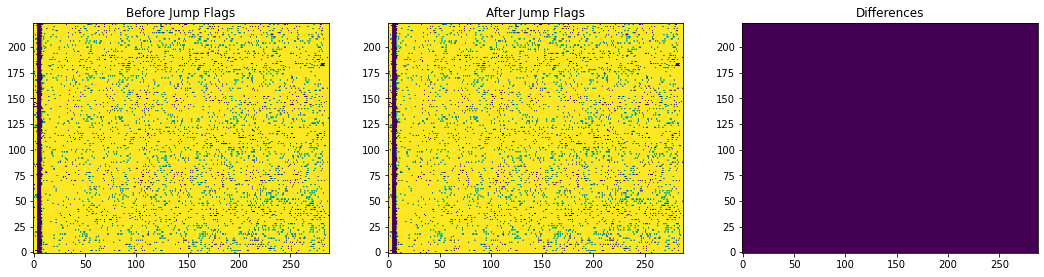

In [61]:
nrows, ncols = 1, 3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows))

ax = axes[0]
ax.set_title("Before Jump Flags")
ax.imshow(jumpflags['refpix'].any(axis=(0, 1))
         )

ax = axes[1]
ax.set_title("After Jump Flags")
ax.imshow(jumpflags['jump'].any(axis=(0, 1))
         )

ax = axes[2]
ax.set_title("Differences")
ax.imshow(jumpflags['jump'].any(axis=(0, 1)) == jumpflags['refpix'].any(axis=(0, 1))
         )

It appears no jumps were flagged

<a id="ramp_fitting"></a>
## Ramp Fit

N.B. This is another step where it is advised to set `maximum_cores` to "half" or "all".

https://jwst-pipeline.readthedocs.io/en/latest/jwst/ramp_fitting/index.html#ramp-fitting-step

This step determines the mean count rate, in units of counts per second, for each pixel by performing a linear fit to the data in the input file.

- save_opt: False 
  - A True/False value that specifies whether to write the optional output product. Default is False.
- opt_name: ''
  - A string that can be used to override the default name for the optional output product.
- int_name: ''
  - A string that can be used to override the default name for the per-integration product.
- suppress_one_group: True
  - A boolean to suppress computations for saturated ramps with only one good (unsaturated) sample. The default is set to True to suppress these computations, which will compute all values for the ramp the same as if the entire ramp were saturated.
- maximum_cores: None
  - The fraction of available cores that will be used for multi-processing in this step. The default value is ‘none’ which does not use multi-processing. The other options are ‘quarter’, ‘half’, and ‘all’. Note that these fractions refer to the total available cores and on most CPUs these include physical and virtual cores. The clock time for the step is reduced almost linearly by the number of physical cores used on all machines. For example, on an Intel CPU with six real cores and 6 virtual cores setting maximum_cores to ‘half’ results in a decrease of a factor of six in the clock time for the step to run. Depending on the system the clock time can also decrease even more with maximum_cores is set to ‘all’.

In [62]:
output_dir = output_parent / "ramp_fit"

In [63]:
results['ramp_fit'] = RampFitStep.call(
    results['jump'], 
    # common
    save_results=True, 
    output_dir=str(output_dir),
    logcfg=generate_log_file(output_dir),
    # step-specific
    save_opt = False,
    opt_name = '',
    int_name = '',
    suppress_one_group = True,
    maximum_cores = 'half'
)

<a id='close_out'></a>
## Close it out

Just so that we can end up with the proper *rate{ints}.fits* filenames

In [64]:
det1 = Detector1Pipeline(output_dir=str(output_parent))

det1.save_model(results['ramp_fit'][0], 
                suffix="rate",
                output_file=results['ramp_fit'][0].meta.filename.split("_0_")[0])

det1.save_model(results['ramp_fit'][1], 
                suffix="rateints",
                output_file=results['ramp_fit'][1].meta.filename.split("_1_")[0])

'stage1/output-steps/jw01386007001_04101_00001_mirimage_rateints.fits'